# Maxout Network Vs Simple CNN Network

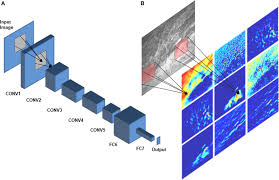

In this file i have made both the simple VGG 3 block model and tried to compare it with Maxout Network . Let's see how it will work out in the end :)

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.models as M
import keras.layers as L
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.constraints import max_norm
from PIL import Image

# Generating Data

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
validation_split=0.2)
training_set = datagen.flow_from_directory('../input/dogs-cats-images/dataset/training_set', 
                                                    target_size = (64, 64), 
                                                    batch_size = 16,subset='training')
validation_set=datagen.flow_from_directory('../input/dogs-cats-images/dataset/training_set',target_size = (64, 64), 
                                                    batch_size = 16,subset='validation')

# Making simple 3 Block VGG Model using Relu

In [ ]:
# Making simple 3 block vgg model
model=M.Sequential()
model.add(L.Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
model.add(L.BatchNormalization(momentum=0.8))
model.add(L.MaxPooling2D(pool_size=(2,2)))
model.add(L.Dropout(0.6))
model.add(L.Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(L.BatchNormalization(momentum=0.8))
model.add(L.MaxPooling2D(pool_size=(2,2)))
model.add(L.Dropout(0.5))
model.add(L.Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
model.add(L.BatchNormalization(momentum=0.8))
model.add(L.MaxPooling2D(pool_size=(2,2)))
model.add(L.Dropout(0.4))
model.add(L.Flatten())
model.add(L.Dense(2,activation='softmax'))

# Compiling Model

In [ ]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) 
earlystopping = EarlyStopping(monitor ="val_accuracy",
                              mode = 'auto', patience = 6,
                              restore_best_weights = True)
adam=keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
                     optimizer=adam,
                     metrics=['accuracy'])

# Fitting Model On Our Data

In [ ]:
model.fit(training_set,validation_data=validation_set,epochs=100,batch_size=100,callbacks=[earlystopping])

# Making MAXOUT Activation Function

![](https://miro.medium.com/max/763/1*pvqVEwK-AS7jCJoDIOtAsQ.png)

A maxout layer is simply a layer where the activation function is the max of the inputs. Even an MLP with 2 maxout units can approximate any function. They give a couple of reasons as to why maxout may be performing well, but the main reason they give is the following --

Dropout can be thought of as a form of model averaging in which a random subnetwork is trained at every iteration and in the end the weights of the different random networks are averaged. Since one cannot average the weights explicitly, an approximation is used. This approximation is exact for a linear network
In maxout, they do not drop the inputs to the maxout layer. Thus the identity of the input outputting the max value for a data point remains unchanged. Thus the dropout only happens in the linear part of the MLP but one can still approximate any function because of the maxout layer.
As the dropout happens in the linear part only, they conjecture that this leads to more efficient model averaging as the averaging approximation is exact for linear networks.

Reference Taken From :https://stats.stackexchange.com/questions/129698/what-is-maxout-in-neural-network

In [ ]:
def maxout_activation_function(inputs,units,axis=None):
    if axis is None:
        axis=-1
    input_shape=inputs.get_shape().as_list()
    n_dims=len(input_shape)
    assert n_dims==4
    num_channels=input_shape[axis]
    if num_channels%units :
        raise ValueError('number of features({}) is not a multiple of num_units({})'.format(num_channels, units))
    input_shape[axis]=units
    input_shape+=[num_channels//units]
    output=K.reshape(inputs,(-1,input_shape[1],input_shape[2],input_shape[3],input_shape[4]))
    output_max=K.max(output,axis=-1,keepdims=False)
    return output_max

# Making Model Using Maxout Activation

In [ ]:
# MAking a second model where we use maxout activation function
max_norm = max_norm(max_value=8, axis=[0, 1, 2])
img_shape=(64,64,3)
inp=L.Input(img_shape)
conv1=L.Conv2D(filters=64,kernel_size=(3,3),activation=None, kernel_constraint=max_norm)(inp)
maxout1=L.Lambda(maxout_activation_function,arguments={'units':32})(conv1)
batch1=L.BatchNormalization(momentum=0.8)(maxout1)
pool1 = L.MaxPooling2D(pool_size=(2,2))(batch1)
drop1= L.Dropout(0.6)(pool1)
conv2=L.Conv2D(filters=128,kernel_size=(3,3),activation=None, kernel_constraint=max_norm)(drop1)
maxout2=L.Lambda(maxout_activation_function,arguments={'units':64})(conv2)
batch2=L.BatchNormalization(momentum=0.8)(maxout2)
pool2 = L.MaxPooling2D(pool_size=(2,2))(batch2)
drop2= L.Dropout(0.5)(pool2)
conv3=L.Conv2D(filters=256,kernel_size=(3,3),activation=None, kernel_constraint=max_norm)(drop2)
maxout3=L.Lambda(maxout_activation_function,arguments={'units':64})(conv3)
batch3=L.BatchNormalization(momentum=0.8)(maxout3)
pool3 = L.MaxPooling2D(pool_size=(2,2))(batch3)
drop3= L.Dropout(0.4)(pool3)
flatten=L.Flatten()(drop3)
dense=L.Dense(2,activation='softmax')(flatten)

In [ ]:
model2=M.Model(inputs=inp,outputs=dense)

# Summary of the model

In [ ]:
model2.summary()

# Compiling the model

In [ ]:
model2.compile(loss='categorical_crossentropy',
                     optimizer=adam,
                     metrics=['accuracy'])

# Fitting the model

In [ ]:
model2.fit(training_set,validation_data=validation_set,epochs=100,batch_size=40,callbacks=[earlystopping])

In [ ]:
history=model2.history.history

# Plotting Loss And Accuracy

In [ ]:
# Plot for training and validation accuracy of the model
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])

In [ ]:
# Plot for training and validation loss of the model
plt.plot(history['loss'])
plt.plot(history['val_loss'])

# The model worked great as we can see that the accuracy increased from 80 to 83 :) Cool :)

# Predicting some of the images

In [ ]:
def make_predictions(path):
    image=Image.open(path)
    plt.imshow(image)
    image=image.resize((64,64))
    arr=np.array(image)
    x=np.expand_dims(arr,axis=0)
    cl=np.argmax(model2.predict(x))
    if cl==0:
        print('Its a cat!!')
    else:
        print('Its a dog!!')

In [ ]:
make_predictions('../input/dogs-cats-images/dataset/test_set/dogs/dog.4004.jpg')

In [ ]:
make_predictions('../input/dogs-cats-images/dataset/test_set/cats/cat.4010.jpg')

# We used it on our testing set and it's workin amazin :)

# Thank you :)